In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import json
import nltk
import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle
from imblearn.over_sampling import ADASYN

In [2]:
#Load data
data = pd.read_csv('fakenews.csv')

In [3]:
# Count the number of rows before removing duplicates
num_rows_before = len(data)

# Remove duplicates
data.drop_duplicates(inplace=True)

# Count the number of rows after removing duplicates
num_rows_after = len(data)

print("Number of rows before removing duplicates:", num_rows_before)
print("Number of rows after removing duplicates:", num_rows_after)

Number of rows before removing duplicates: 3206
Number of rows after removing duplicates: 3005


In [4]:
X = data['article']
y = data['label']

In [5]:
# Split the data into train (90%) and test (10%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Split the train set into train (70%) and validation (30%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

In [6]:
# Show the number of rows for train, test, and validation sets
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 1892
Validation set size: 812
Test set size: 301


In [7]:
# Count the occurrences of each class label in train, test, and validation sets
train_label_counts = y_train.value_counts()
test_label_counts = y_test.value_counts()
val_label_counts = y_val.value_counts()

print("\nTrain set label counts:")
print(train_label_counts)
print("\nTest set label counts:")
print(test_label_counts)
print("\nValidation set label counts:")
print(val_label_counts)


Train set label counts:
label
1    950
0    942
Name: count, dtype: int64

Test set label counts:
label
1    151
0    150
Name: count, dtype: int64

Validation set label counts:
label
1    408
0    404
Name: count, dtype: int64


In [9]:
ps = PorterStemmer()
with open('stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

def preprocess(text):
    tokens = nltk.word_tokenize(text)
    stems = [ps.stem(token) for token in tokens]
    filtered = [stem for stem in stems if stem not in stopwords]
    return filtered

In [10]:
# Apply preprocess function to X_train
X_train = X_train.apply(preprocess)

# Apply preprocess function to X_val
X_val = X_val.apply(preprocess)

In [11]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train.apply(lambda x: ' '.join(x)))
X_val_tfidf = vectorizer.transform(X_val.apply(lambda x: ' '.join(x)))

In [12]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']
# base_models = [('MNB', mnb), ('LR', lr), ('RF', rf), ('KNN', knn), ('SVM', svm)]

In [13]:
# Define the parameter grid
param_grid = {'penalty': ['l2'], 'C': [1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear']}

# Define the GridSearchCV
lr_grid = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

In [14]:
lr_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='accuracy')

In [15]:
print("Best parameters: ", lr_grid.best_params_)
print("Accuracy: {:.2f}%".format(lr_grid.best_score_ * 100))

Best parameters:  {'C': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 94.93%


In [16]:
best_meta = lr_grid.best_estimator_

In [17]:
stack = StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta, cv=5)
stack.fit(X_train_tfidf, y_train)

StackingClassifier(cv=5,
                   estimators=[('MNB', MultinomialNB()),
                               ('LR', LogisticRegression()),
                               ('RF', RandomForestClassifier()),
                               ('KNN', KNeighborsClassifier()),
                               ('SVM', SVC(probability=True))],
                   final_estimator=LogisticRegression(C=1000,
                                                      solver='liblinear'))

Metrics for MNB:
Accuracy: 0.8509852216748769
Precision: 0.7775628626692457
Recall: 0.9852941176470589
F1 Score: 0.8691891891891892
AUC: 0.9801980198019802
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       404
           1       0.78      0.99      0.87       408

    accuracy                           0.85       812
   macro avg       0.88      0.85      0.85       812
weighted avg       0.88      0.85      0.85       812



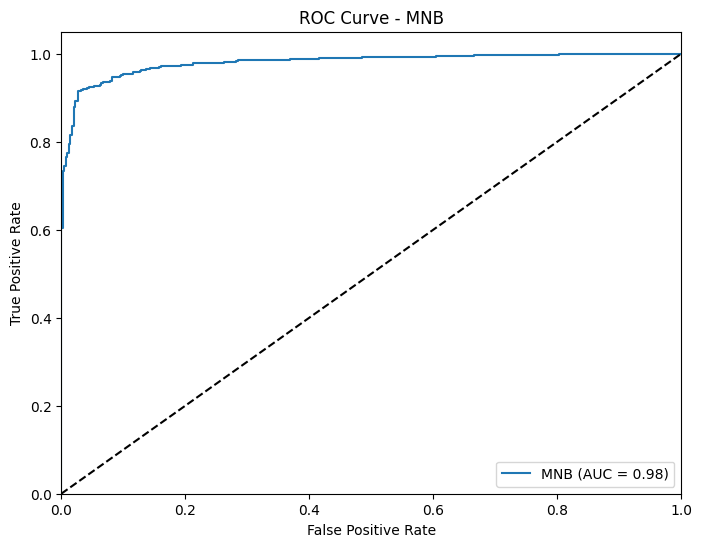

Metrics for LR:
Accuracy: 0.9322660098522167
Precision: 0.9560723514211886
Recall: 0.9068627450980392
F1 Score: 0.9308176100628931
AUC: 0.9877450980392157
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       404
           1       0.96      0.91      0.93       408

    accuracy                           0.93       812
   macro avg       0.93      0.93      0.93       812
weighted avg       0.93      0.93      0.93       812



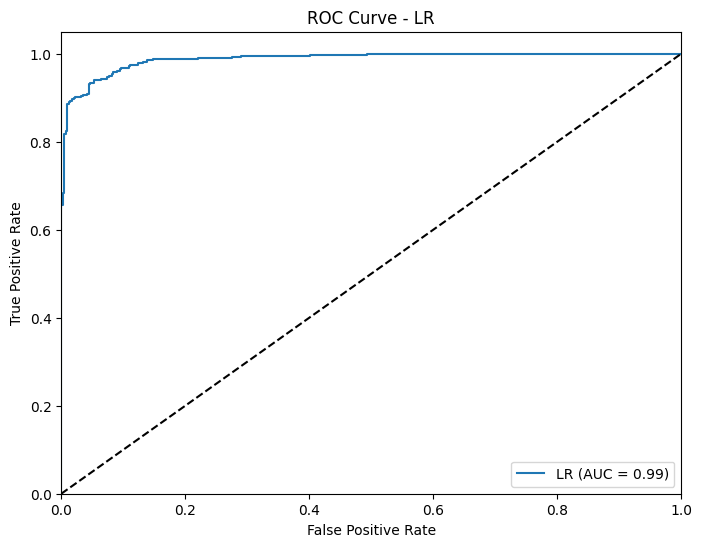

Metrics for RF:
Accuracy: 0.9445812807881774
Precision: 0.9437652811735942
Recall: 0.946078431372549
F1 Score: 0.944920440636475
AUC: 0.9858037274315667
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       404
           1       0.94      0.95      0.94       408

    accuracy                           0.94       812
   macro avg       0.94      0.94      0.94       812
weighted avg       0.94      0.94      0.94       812



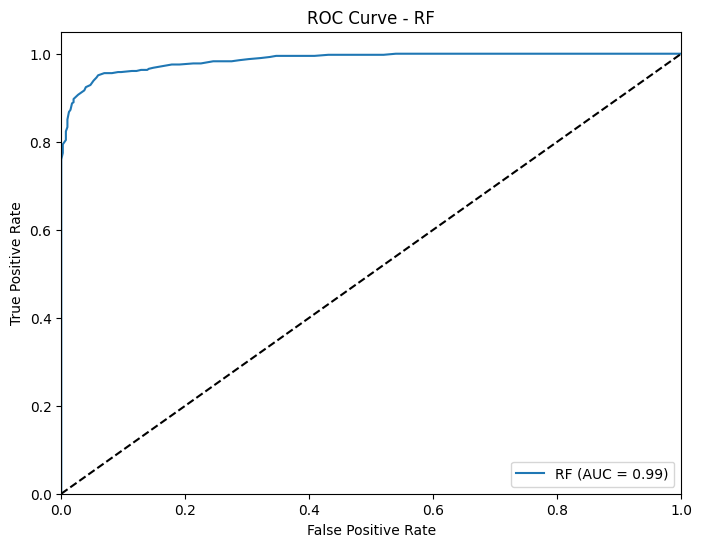

Metrics for KNN:
Accuracy: 0.8879310344827587
Precision: 0.8394004282655246
Recall: 0.9607843137254902
F1 Score: 0.896
AUC: 0.9528034604931082
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88       404
           1       0.84      0.96      0.90       408

    accuracy                           0.89       812
   macro avg       0.90      0.89      0.89       812
weighted avg       0.90      0.89      0.89       812



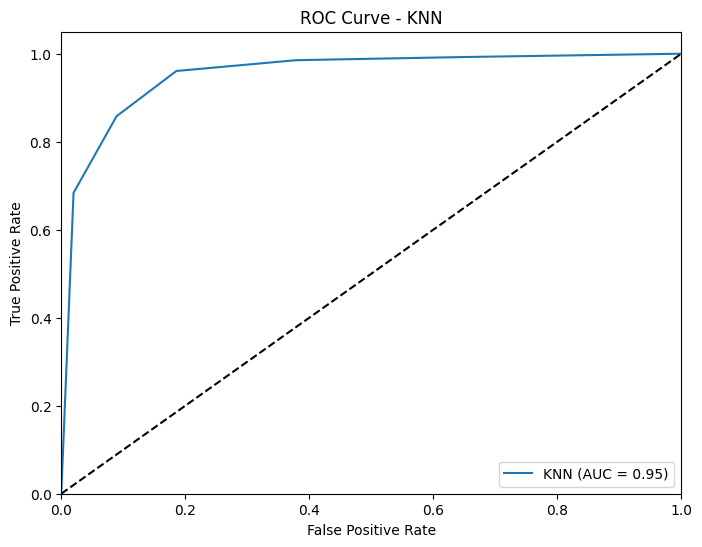

Metrics for SVM:
Accuracy: 0.9495073891625616
Precision: 0.9816272965879265
Recall: 0.9166666666666666
F1 Score: 0.9480354879594424
AUC: 0.9906328868180936
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       404
           1       0.98      0.92      0.95       408

    accuracy                           0.95       812
   macro avg       0.95      0.95      0.95       812
weighted avg       0.95      0.95      0.95       812



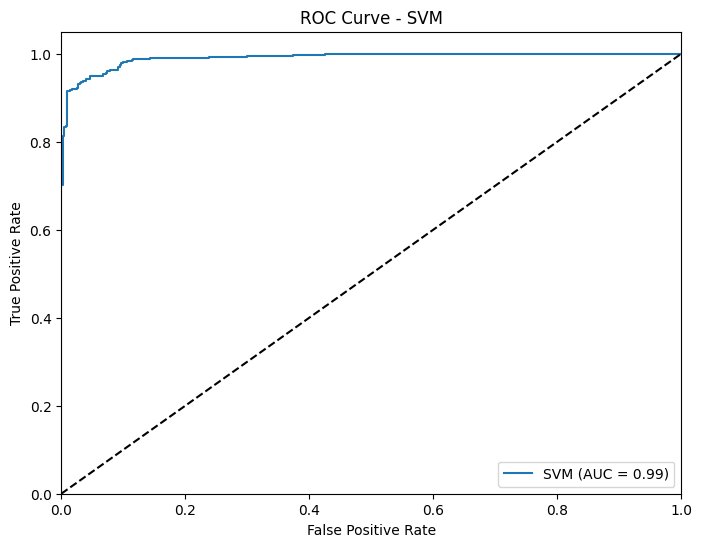

In [18]:
# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])


# Evaluate base models
for model, name in zip(base_models, base_names):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    y_prob = model.predict_proba(X_val_tfidf)[:, 1]  # Probability for positive class for ROC curve

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 0.9593596059113301
Precision: 0.9539951573849879
Recall: 0.9656862745098039
F1 Score: 0.9598051157125457
AUC: 0.9942729567074353
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       404
           1       0.95      0.97      0.96       408

    accuracy                           0.96       812
   macro avg       0.96      0.96      0.96       812
weighted avg       0.96      0.96      0.96       812



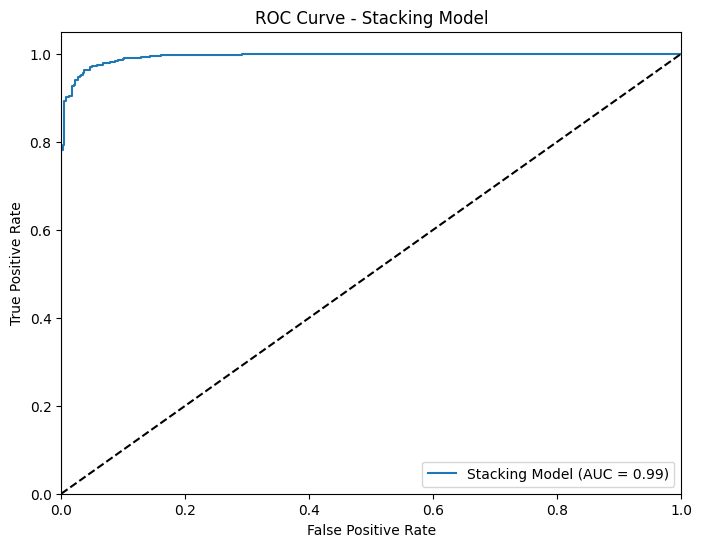

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.850985  0.777563  0.985294  0.869189  0.980198
LR              0.932266  0.956072  0.906863  0.930818  0.987745
RF              0.944581  0.943765  0.946078   0.94492  0.985804
KNN             0.887931    0.8394  0.960784     0.896  0.952803
SVM             0.949507  0.981627  0.916667  0.948035  0.990633
Stacking Model   0.95936  0.953995  0.965686  0.959805  0.994273


In [19]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_val_tfidf)
stack_y_prob = stack.predict_proba(X_val_tfidf)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_val, stack_y_pred)
stack_precision = precision_score(y_val, stack_y_pred)
stack_recall = recall_score(y_val, stack_y_pred)
stack_f1 = f1_score(y_val, stack_y_pred)
stack_auc = roc_auc_score(y_val, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_val, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_val, stack_y_prob)
stack_roc_auc = roc_auc_score(y_val, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

In [20]:
# Save the model using joblib
joblib.dump(stack, 'stackmodel_lr_new.joblib')

['stackmodel_lr_new.joblib']